In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
import os

os.environ["OPENBLAS_NUM_THREADS"] = "1"
warnings.filterwarnings('ignore')

# Load the datasets
X = pd.read_csv('X_train.csv')
y = pd.read_csv('y_train.csv')

# Combine into one DataFrame for EDA
df = X.copy()
df['label'] = y.values.ravel()  # flatten in case it's a DataFrame

print("Feature shape:", X.shape)
print("Label shape:", y.shape)
df.head()

Feature shape: (10000, 300)
Label shape: (10000, 1)


,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,label
0,0.617940,-0.39198,0.13278,0.032551,0.55201,0.83393,-0.837550,-0.87406,0.43930,0.26826,...,0.36452,1.57530,-0.620320,-0.25371,-0.44775,-0.038273,-0.019938,-0.195500,0.428830,10
1,0.333860,-1.54910,1.67050,0.793560,0.80251,-0.07206,-0.068276,3.30240,0.52045,0.68572,...,1.74080,1.28660,-0.013396,-1.53930,0.83354,0.472610,0.513030,-0.743140,1.219900,5
2,0.040399,-0.60807,1.62080,-0.355970,0.12105,1.35250,0.373200,1.11170,0.35894,-0.34410,...,-0.24763,0.50705,0.708220,-0.60083,0.91104,0.009979,-0.475990,-0.094731,-0.008521,5
3,1.723600,0.19529,1.03880,-3.009100,-0.33222,0.91067,0.666690,0.71725,3.05850,1.48990,...,-0.25284,-1.30780,-0.445660,0.27918,0.26467,-0.149360,1.492900,-1.176700,-1.854500,5
4,-1.032300,1.90010,-1.46010,0.383710,-0.51039,0.74481,-0.914660,-0.86588,-0.34426,0.86965,...,0.06020,-1.07900,-0.617050,1.18450,-0.21063,-0.105870,-0.412040,1.409700,0.133350,5


## Exploratory Data Analysis


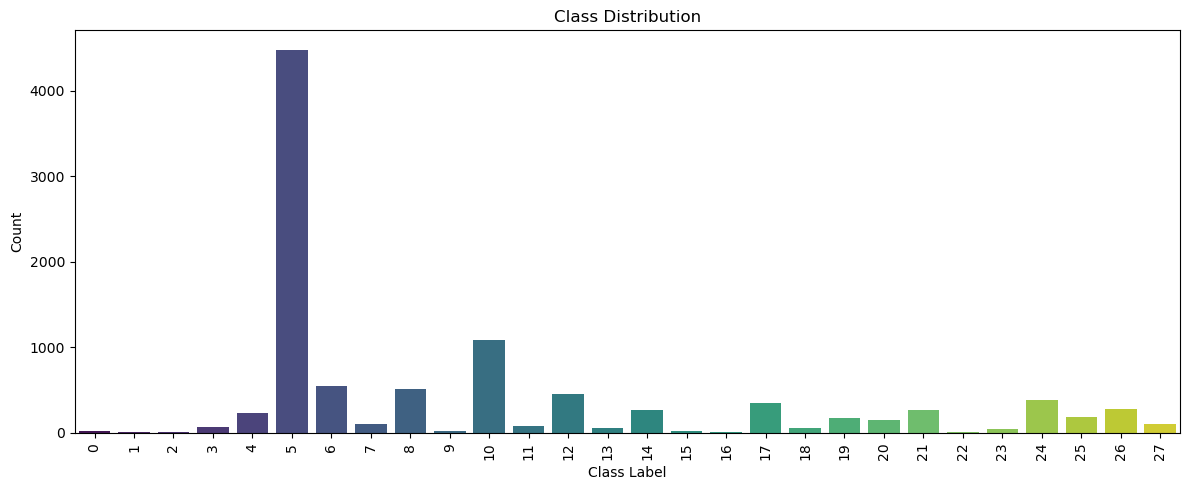

Class counts:
 label
0       18
1        7
2        7
3       65
4      238
5     4479
6      553
7      103
8      516
9       25
10    1081
11      78
12     457
13      62
14     264
15      26
16       6
17     354
18      60
19     177
20     153
21     269
22       7
23      41
24     385
25     184
26     278
27     107
Name: count, dtype: int64


In [2]:
# Plot graph of class counts
class_counts = df['label'].value_counts().sort_index()

plt.figure(figsize=(12, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title("Class Distribution")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

print("Class counts:\n", class_counts)


In [3]:
# Summary stats for a few features
print("Summary stats:\n", X.iloc[:, :5].describe())

# Check for missing values
missing_total = X.isnull().sum().sum()
print(f"\nTotal missing values in X: {missing_total}")


Summary stats:
                   0             1             2             3             4
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000
mean      -0.021449     -0.000912      0.012368      0.045447      0.034961
std        0.986789      1.008141      1.009709      0.985909      0.988168
min       -8.163800    -11.982000     -3.502000     -4.704000     -7.017800
25%       -0.629273     -0.601035     -0.652678     -0.567387     -0.589565
50%       -0.026099      0.026874     -0.042700      0.069475      0.026490
75%        0.581712      0.627327      0.620073      0.677163      0.639463
max        4.575000      4.232200      6.586800      3.867900      7.705200

Total missing values in X: 0


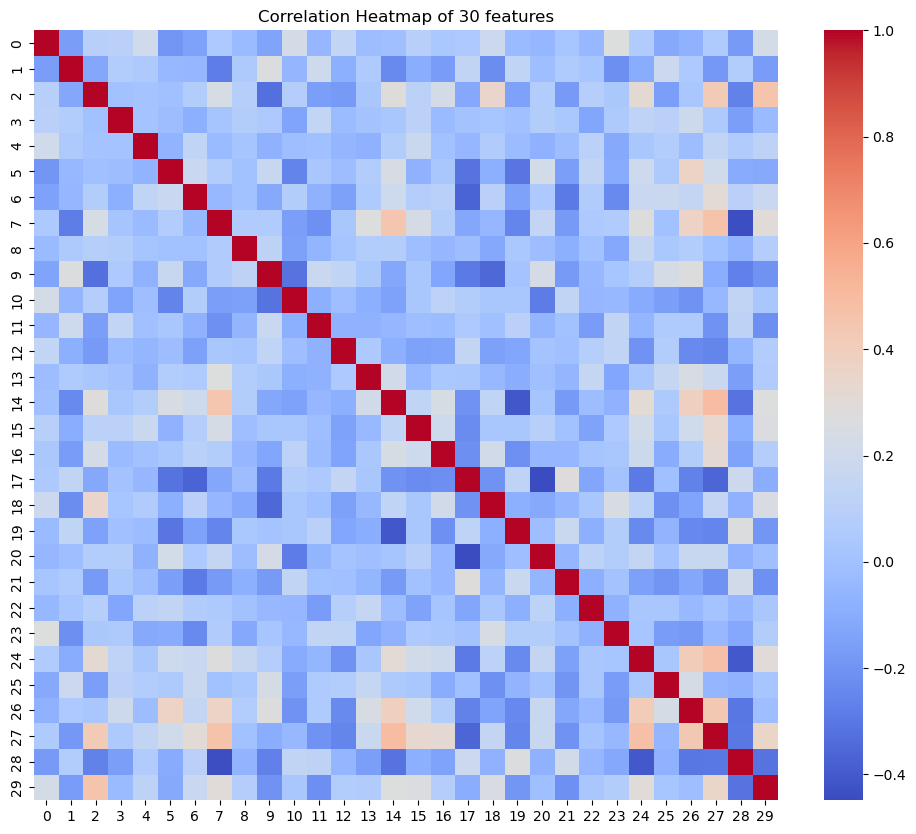

In [4]:
# PLot correlation heatmap

plt.figure(figsize=(12, 10))
sns.heatmap(X.iloc[:, :30].corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap of 30 features")
plt.show()


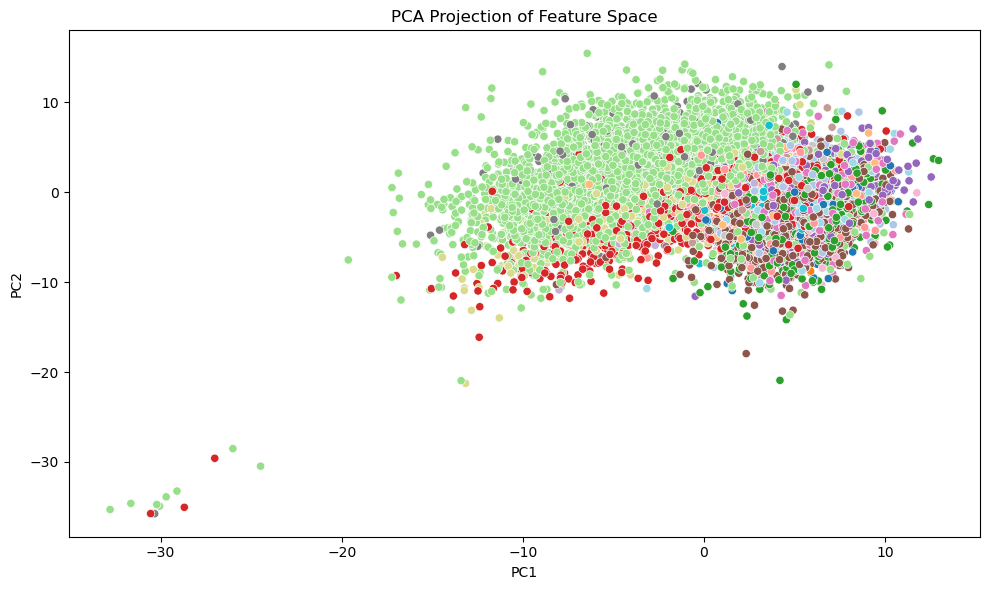

In [5]:
# Plot PCA graph

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['label'], palette='tab20', legend=False)
plt.title("PCA Projection of Feature Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()


## Models

### Random Forest


In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from imblearn.over_sampling import SMOTE

# Setup
X_data = X
y_data = y.values.ravel()

from sklearn.model_selection import train_test_split

# Flatten labels if needed
y_flat = y.values.ravel()

# Split: 80% training, 20% validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X, y_flat,
    test_size=0.2,
    random_state=42,
    stratify=y_flat
)

# SMOTE for oversampling

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42, k_neighbors=2)  # lower this if needed
X_resampled, y_resampled = smote.fit_resample(X_train_split, y_train_split)

print("Resampled shape:", X_resampled.shape)




Resampled shape: (100324, 300)


In [9]:
from collections import Counter

resampled_counts = Counter(y_resampled)
print("Class distribution after resampling:")
for cls, count in sorted(resampled_counts.items()):
    print(f"Class {cls}: {count}")


Class distribution after resampling:
Class 0: 3583
Class 1: 3583
Class 2: 3583
Class 3: 3583
Class 4: 3583
Class 5: 3583
Class 6: 3583
Class 7: 3583
Class 8: 3583
Class 9: 3583
Class 10: 3583
Class 11: 3583
Class 12: 3583
Class 13: 3583
Class 14: 3583
Class 15: 3583
Class 16: 3583
Class 17: 3583
Class 18: 3583
Class 19: 3583
Class 20: 3583
Class 21: 3583
Class 22: 3583
Class 23: 3583
Class 24: 3583
Class 25: 3583
Class 26: 3583
Class 27: 3583


Validation Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.29      0.15      0.20        13
           4       0.50      0.46      0.48        48
           5       0.86      0.96      0.91       896
           6       0.86      0.91      0.89       111
           7       0.60      0.29      0.39        21
           8       0.60      0.82      0.69       103
           9       0.00      0.00      0.00         5
          10       0.64      0.83      0.72       216
          11       0.50      0.62      0.56        16
          12       0.42      0.53      0.47        91
          13       0.00      0.00      0.00        12
          14       0.07      0.02      0.03        53
          15       0.71      1.00      0.83         5
          16       0.00      0.00      0.00    

<Figure size 1000x800 with 0 Axes>

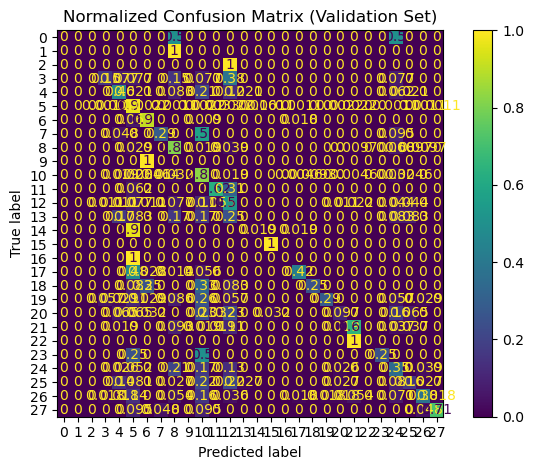

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt

# Train the model
model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced_subsample'
)

model.fit(X_resampled, y_resampled)

# Predict on validation set
y_val_pred = model.predict(X_val_split)

# Evaluation
print("Validation Classification Report:")
print(classification_report(y_val_split, y_val_pred))

# Macro F1 Score
val_f1 = f1_score(y_val_split, y_val_pred, average='macro')
print(f"Macro F1 Score on Validation Set: {val_f1:.4f}")

# Confusion Matrix
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_estimator(model, X_val_split, y_val_split, cmap='viridis', normalize='true')
plt.title("Normalized Confusion Matrix (Validation Set)")
plt.tight_layout()
plt.show()


In [9]:
X_test_1 = pd.read_csv("X_test_1.csv")
print("Test set shape:", X_test_1.shape)


Test set shape: (1000, 300)


In [10]:
# Predict class probabilities for submission
y_test_proba = model.predict_proba(X_test_1)

# Predict actual labels (for your own inspection)
y_test_labels = model.predict(X_test_1)

print("Predicted probabilities shape:", y_test_proba.shape)
print("Predicted class labels:", y_test_labels[:10])


Predicted probabilities shape: (1000, 28)
Predicted class labels: [ 5 12 10  6 12  7  5  5  6 26]


### Balanced Random Forest


In [11]:
from imblearn.ensemble import BalancedRandomForestClassifier

brf_model = BalancedRandomForestClassifier(
    n_estimators=100,
    random_state=42,
    sampling_strategy='auto'  # Can also set manually
)

brf_model.fit(X_resampled, y_resampled)
y_val_pred_brf = brf_model.predict(X_val_split)

print("Balanced RF Classification Report:")
print(classification_report(y_val_split, y_val_pred_brf))
print("Macro F1 (BRF):", f1_score(y_val_split, y_val_pred_brf, average='macro'))


Balanced RF Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00        13
           4       0.50      0.52      0.51        48
           5       0.86      0.96      0.91       896
           6       0.84      0.92      0.88       111
           7       0.71      0.24      0.36        21
           8       0.61      0.80      0.69       103
           9       0.00      0.00      0.00         5
          10       0.66      0.85      0.74       216
          11       0.47      0.56      0.51        16
          12       0.46      0.54      0.50        91
          13       0.00      0.00      0.00        12
          14       0.00      0.00      0.00        53
          15       0.80      0.80      0.80         5
          16       0.00      0.00      0.00   

### Comparing RF and BRF

In [12]:
models = {
    "Random Forest": model,
    "Balanced Random Forest": brf_model
}

for name, clf in models.items():
    clf.fit(X_resampled, y_resampled)
    preds = clf.predict(X_val_split)
    print(f"\n{name} Macro F1:", f1_score(y_val_split, preds, average='macro'))
    print(classification_report(y_val_split, preds))



Random Forest Macro F1: 0.37954179011447514
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.29      0.15      0.20        13
           4       0.50      0.46      0.48        48
           5       0.86      0.96      0.91       896
           6       0.86      0.91      0.89       111
           7       0.60      0.29      0.39        21
           8       0.60      0.82      0.69       103
           9       0.00      0.00      0.00         5
          10       0.64      0.83      0.72       216
          11       0.50      0.62      0.56        16
          12       0.42      0.53      0.47        91
          13       0.00      0.00      0.00        12
          14       0.07      0.02      0.03        53
          15       0.71      1.00      0.83         5
          16       0.00      0.00   

### Ensemble of RF and BRF

In [14]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[
        ('rf', model),
        ('brf', brf_model)
    ],
    voting='soft'
)

voting_clf.fit(X_resampled, y_resampled)
voting_preds = voting_clf.predict(X_val_split)

print("VotingClassifier Macro F1:", f1_score(y_val_split, voting_preds, average='macro'))


VotingClassifier Macro F1: 0.3783804217840808


### Decision Tree

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, f1_score

# Train C4.5-like Decision Tree
dt_model = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=42, class_weight='balanced')
dt_model.fit(X_train_split, y_train_split)

# Predict on validation set
y_pred_dt = dt_model.predict(X_val_split)

# Evaluate
print("C4.5-style Decision Tree Report:")
print(classification_report(y_val_split, y_pred_dt))
print("Macro F1 Score:", f1_score(y_val_split, y_pred_dt, average='macro'))


C4.5-style Decision Tree Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.12      0.15      0.14        13
           4       0.23      0.21      0.22        48
           5       0.79      0.81      0.80       896
           6       0.66      0.64      0.65       111
           7       0.10      0.10      0.10        21
           8       0.46      0.42      0.44       103
           9       0.00      0.00      0.00         5
          10       0.47      0.45      0.46       216
          11       0.09      0.12      0.10        16
          12       0.18      0.19      0.18        91
          13       0.00      0.00      0.00        12
          14       0.08      0.08      0.08        53
          15       0.50      0.20      0.29         5
          16       1.00      1.00      1.00     

### SVC

In [18]:
from sklearn.svm import SVC

svm_model = SVC(kernel='linear', probability=True, class_weight='balanced')
svm_model.fit(X_resampled, y_resampled)
y_pred_svm = svm_model.predict(X_val_split)

print("SVM Report:")
print(classification_report(y_val_split, y_pred_svm))
print("Macro F1 Score:", f1_score(y_val_split, y_pred_svm, average='macro'))


SVM Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.33      0.62      0.43        13
           4       0.44      0.65      0.52        48
           5       0.92      0.76      0.84       896
           6       0.83      0.94      0.88       111
           7       0.50      0.48      0.49        21
           8       0.63      0.67      0.65       103
           9       0.00      0.00      0.00         5
          10       0.80      0.79      0.79       216
          11       0.53      0.50      0.52        16
          12       0.52      0.53      0.52        91
          13       0.00      0.00      0.00        12
          14       0.12      0.47      0.19        53
          15       1.00      0.80      0.89         5
          16       1.00      1.00      1.00         1
          17   

### XGB

In [19]:
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb
import numpy as np

classes = np.unique(y_train_split)
weights = comp0.75ute_class_weight('balanced', classes=classes, y=y_train_split)
weight_dict = dict(zip(classes, weights))

# convert to list for booster
scale_weights = [weight_dict[c] for c in y_train_split]

xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=28,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

xgb_model.fit(X_train_split, y_train_split, sample_weight=scale_weights)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=28, ...)

In [20]:
y_pred_xgb = xgb_model.predict(X_val_split)

print("XGB Report:")
print(classification_report(y_val_split, y_pred_xgb))
print("Macro F1 Score:", f1_score(y_val_split, y_pred_xgb, average='macro'))

XGB Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.45      0.38      0.42        13
           4       0.52      0.52      0.52        48
           5       0.90      0.95      0.92       896
           6       0.82      0.93      0.87       111
           7       0.47      0.33      0.39        21
           8       0.66      0.75      0.70       103
           9       0.00      0.00      0.00         5
          10       0.73      0.86      0.79       216
          11       0.44      0.50      0.47        16
          12       0.49      0.47      0.48        91
          13       0.38      0.25      0.30        12
          14       0.00      0.00      0.00        53
          15       0.50      0.40      0.44         5
          16       0.00      0.00      0.00         1
          17   

### Selective SMOTE

In [14]:
# Imports
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier

# Load and flatten labels
X_data = X  
y_data = y.values.ravel()  

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_data, y_data, test_size=0.2, random_state=42, stratify=y_data
)

# SMOTE only for classes with 6+ samples and <300
class_counts = Counter(y_train_split)
sampling_strategy = {cls: 300 for cls, count in class_counts.items() if 5 < count < 300}

smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42, k_neighbors=2)
X_resampled, y_resampled = smote.fit_resample(X_train_split, y_train_split)

print("Original training shape:", X_train_split.shape)
print("Resampled shape:", X_resampled.shape)

# Train Balanced Random Forest
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
brf.fit(X_resampled, y_resampled)

# 5Predict on validation set
y_val_pred = brf.predict(X_val_split)

# Evaluation
print("\nBalanced Random Forest - Validation Classification Report:")
print(classification_report(y_val_split, y_val_pred))
val_f1 = f1_score(y_val_split, y_val_pred, average='macro')
print(f"Macro F1 Score on Validation Set: {val_f1:.4f}")


Original training shape: (8000, 300)
Resampled shape: (12282, 300)

Balanced Random Forest - Validation Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.15      0.38      0.22        13
           4       0.30      0.38      0.33        48
           5       0.91      0.41      0.57       896
           6       0.66      0.48      0.55       111
           7       0.25      0.62      0.35        21
           8       0.49      0.35      0.41       103
           9       0.02      0.40      0.03         5
          10       0.80      0.15      0.26       216
          11       0.22      0.81      0.34        16
          12       0.45      0.10      0.16        91
          13       0.09      0.17      0.12        12
          14       0.06      0.43      0.11        53
        

### Ensemble (XGB, BRF, LR)

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
import xgboost as xgb
from sklearn.utils.class_weight import compute_class_weight

# 1Logistic Regression (with class weights)
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

# XGBoost (with sample weights)
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=28,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

# Compute sample weights for XGBoost
classes = np.unique(y_resampled)
weights = compute_class_weight('balanced', classes=classes, y=y_resampled)
weight_dict = dict(zip(classes, weights))
sample_weights = np.array([weight_dict[c] for c in y_resampled])

xgb_model.fit(X_resampled, y_resampled, sample_weight=sample_weights)

# Balanced Random Forest (already trained above as `brf`)

# Voting Ensemble (soft voting)
ensemble = VotingClassifier(
    estimators=[
        ('brf', brf),
        ('xgb', xgb_model),
        ('lr', lr_model)
    ],
    voting='soft'
)

# Fit ensemble on resampled data
ensemble.fit(X_resampled, y_resampled)

# Predict and evaluate on validation set
y_val_pred_ensemble = ensemble.predict(X_val_split)

print("\n Ensemble Voting Classifier Report:")
print(classification_report(y_val_split, y_val_pred_ensemble))
ensemble_f1 = f1_score(y_val_split, y_val_pred_ensemble, average='macro')
print(f"Macro F1 Score on Validation Set (Ensemble): {ensemble_f1:.4f}")



 Ensemble Voting Classifier Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.38      0.62      0.47        13
           4       0.48      0.58      0.53        48
           5       0.92      0.93      0.92       896
           6       0.88      0.92      0.90       111
           7       0.69      0.52      0.59        21
           8       0.66      0.75      0.70       103
           9       0.00      0.00      0.00         5
          10       0.84      0.81      0.82       216
          11       0.63      0.75      0.69        16
          12       0.57      0.57      0.57        91
          13       0.00      0.00      0.00        12
          14       0.06      0.04      0.05        53
          15       1.00      1.00      1.00         5
          16       1.00      1.00      1.00 